## Iris Data - predict categories (1, 2, or 3) using classical and quantum machine learning models

In [19]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import pandas as pd

from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import RealAmplitudes

from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals

from qiskit.primitives import StatevectorSampler as Sampler

import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

import time

### Exploratory Data Analysis

In [30]:
iris_data = load_iris()
print(type(iris_data))

<class 'sklearn.utils._bunch.Bunch'>


In [3]:
#print(iris_data.DESCR)

Map Feature Data onto [0, 1]

In [33]:
features = iris_data.data
labels = iris_data.target

features = MinMaxScaler().fit_transform(features)
print(type(features), features.shape)
print(type(labels), labels.shape)

<class 'numpy.ndarray'> (150, 4)
<class 'numpy.ndarray'> (150,)


In [4]:
df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)

#sns.pairplot(df, hue="class", palette="tab10")

In [5]:
algorithm_globals.random_seed = 123

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

### Train Classical Support Vector Classifier on Iris Data (features transformed to [0, 1])

In [6]:
svc = SVC()
_ = svc.fit(train_features, train_labels)  # suppress printing the return value

In [7]:
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.99
Classical SVC on the test dataset:     0.97


### Train Quantum Machine Learning Model on Iris Data

In [8]:
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
#feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

In [9]:
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
#ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

In [10]:
optimizer = COBYLA(maxiter=100)

In [13]:
sampler = Sampler()

In [15]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

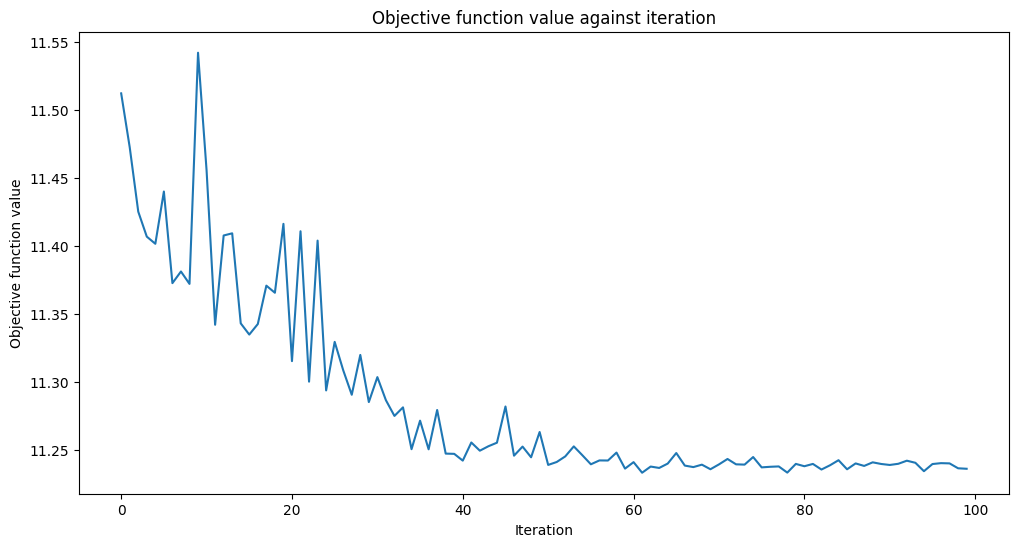

Training time: 76 seconds


In [17]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [18]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.64
Quantum VQC on the test dataset:     0.63


In [21]:
features = PCA(n_components=2).fit_transform(features)

plt.rcParams["figure.figsize"] = (6, 6)
#sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette="tab10")

In [22]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

svc.fit(train_features, train_labels)

train_score_c2 = svc.score(train_features, train_labels)
test_score_c2 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c2:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c2:.2f}")

Classical SVC on the training dataset: 0.97
Classical SVC on the test dataset:     0.90


In [23]:
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)

In [24]:
optimizer = COBYLA(maxiter=40)

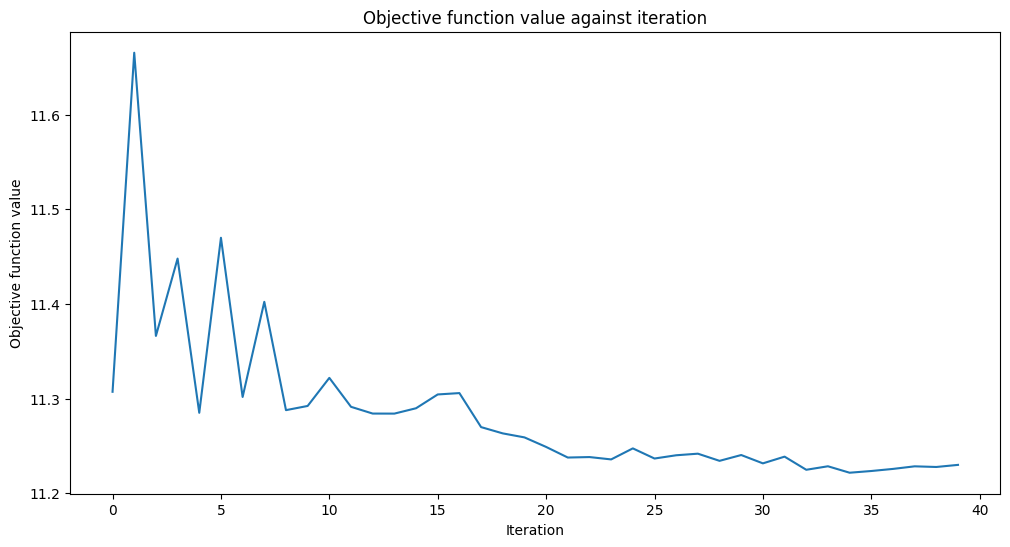

Training time: 23 seconds


In [25]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

# make the objective function plot look nicer.
plt.rcParams["figure.figsize"] = (12, 6)


start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [26]:
train_score_q2_ra = vqc.score(train_features, train_labels)
test_score_q2_ra = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using RealAmplitudes: {train_score_q2_ra:.2f}")
print(f"Quantum VQC on the test dataset using RealAmplitudes:     {test_score_q2_ra:.2f}")

Quantum VQC on the training dataset using RealAmplitudes: 0.52
Quantum VQC on the test dataset using RealAmplitudes:     0.40


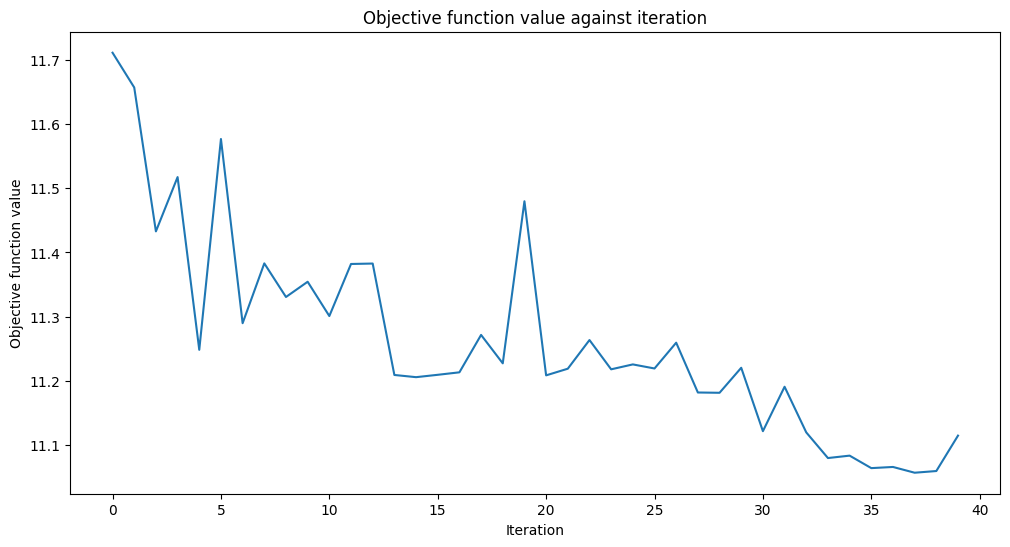

Training time: 24 seconds


In [27]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=num_features, reps=3)
optimizer = COBYLA(maxiter=40)

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [28]:
train_score_q2_eff = vqc.score(train_features, train_labels)
test_score_q2_eff = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using EfficientSU2: {train_score_q2_eff:.2f}")
print(f"Quantum VQC on the test dataset using EfficientSU2:     {test_score_q2_eff:.2f}")

Quantum VQC on the training dataset using EfficientSU2: 0.64
Quantum VQC on the test dataset using EfficientSU2:     0.63


In [29]:
print(f"Model                           | Test Score | Train Score")
print(f"SVC, 4 features                 | {train_score_c4:10.2f} | {test_score_c4:10.2f}")
print(f"VQC, 4 features, RealAmplitudes | {train_score_q4:10.2f} | {test_score_q4:10.2f}")
print(f"----------------------------------------------------------")
print(f"SVC, 2 features                 | {train_score_c2:10.2f} | {test_score_c2:10.2f}")
print(f"VQC, 2 features, RealAmplitudes | {train_score_q2_ra:10.2f} | {test_score_q2_ra:10.2f}")
print(f"VQC, 2 features, EfficientSU2   | {train_score_q2_eff:10.2f} | {test_score_q2_eff:10.2f}")

Model                           | Test Score | Train Score
SVC, 4 features                 |       0.99 |       0.97
VQC, 4 features, RealAmplitudes |       0.64 |       0.63
----------------------------------------------------------
SVC, 2 features                 |       0.97 |       0.90
VQC, 2 features, RealAmplitudes |       0.52 |       0.40
VQC, 2 features, EfficientSU2   |       0.64 |       0.63


<br><br>

The classical models perform better than their quantum counterparts, but classical ML has come a long way, and quantum ML has yet to reach that level of maturity. As we can see, we achieved the best results using a classical support vector machine. But the quantum model trained on four features was also quite good. When we reduced the number of features, the performance of all models went down as expected. So, if resources permit training a model on a full-featured dataset without any reduction, you should train such a model. If not, you may expect to compromise between dataset size, training time, and score.

Another observation is that even a simple ansatz change can lead to better results. The two-feature model with the EfficientSU2 ansatz performs better than the one with RealAmplitudes. That means the choice of hyperparameters plays the same critical role in quantum ML as in classical ML, and searching for optimal hyperparameters may take a long time. You may apply the same techniques we use in classical ML, such as random/grid or more sophisticated approaches.